# Just an initial exploration of the data

For a more thorough and streamlined notebook - check GloVe_LSTM.ipynb... Modeling_Evaluation.ipynb is a great supplementary notebook to see my evaluation thought process

In [2]:
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [3]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Keyword and Location are the main missing features

### Modeling

In [4]:
X = df_train['text']
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 972)

In [5]:
y.value_counts(normalize=True)

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

#### Logreg

In [6]:
logr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logr', LogisticRegression())
])

In [ ]:
logr_params = {
        'tfidf__max_features': [2000,2500],
        'tfidf__min_df': [1,5,10],
        'tfidf__max_df': [0.9, 0.95],
        'tfidf__stop_words': ['english', None],
        'tfidf__ngram_range': [(1, 2)],
        'logr__C': [0.1, 1, 10],
        'logr__penalty': ['l2'], #
        'logr__solver': ['liblinear']
    }

In [ ]:
gs_lr = GridSearchCV(logr, logr_params, cv=5, n_jobs=1)

In [ ]:
gs_lr.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('logr', LogisticRegression())]),
             n_jobs=1,
             param_grid={'logr__C': [0.1, 1, 10], 'logr__penalty': ['l2'],
                         'logr__solver': ['liblinear'],
                         'tfidf__max_df': [0.9, 0.95],
                         'tfidf__max_features': [2000, 2500],
                         'tfidf__min_df': [1, 5, 10],
                         'tfidf__ngram_range': [(1, 2)],
                         'tfidf__stop_words': ['english', None]})

In [ ]:
gs_lr.best_params_

{'logr__C': 1,
 'logr__penalty': 'l2',
 'logr__solver': 'liblinear',
 'tfidf': TfidfVectorizer(max_df=0.9, max_features=2500, ngram_range=(1, 2),
                 stop_words='english'),
 'tfidf__max_df': 0.9,
 'tfidf__max_features': 2500,
 'tfidf__min_df': 1,
 'tfidf__ngram_range': (1, 2),
 'tfidf__stop_words': 'english'}

In [ ]:
gs_lr.score(X_train,y_train), gs_lr.score(X_test,y_test)

(0.859520056051848, 0.7962184873949579)

In [ ]:
# Get predictions
preds = gs_lr.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

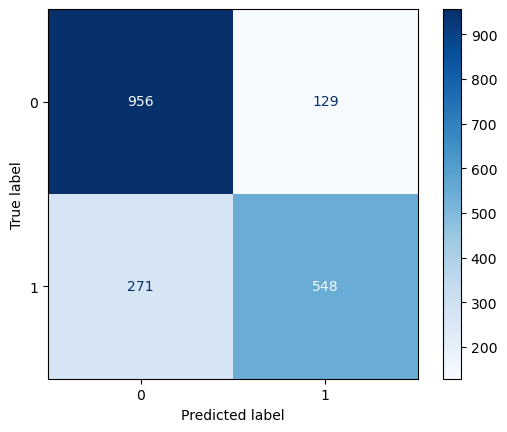

In [ ]:
# View confusion matrix
ConfusionMatrixDisplay.from_estimator(gs_lr, X_test, y_test, cmap='Blues', values_format='d');

In [ ]:
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': gs_lr.predict_proba(X_test)[:,1]})

pred_df.head()

,true_values,pred_probs
421,0,0.258008
5047,0,0.671224
5046,0,0.385309
1881,0,0.175295
6543,0,0.210184


#### MNB

In [ ]:
pipe =Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

In [ ]:
pipe_params = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__max_features': [1000, 5000, 10000],
    'tfidf__min_df': [1, 2, 3],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__stop_words': [None, 'english'],
    'mnb__alpha': [0.1, 0.5, 1.0],
}

In [ ]:
gs = GridSearchCV(pipe, pipe_params, cv=5, n_jobs=1 )

In [ ]:
gs.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             n_jobs=1,
             param_grid={'mnb__alpha': [0.1, 0.5, 1.0],
                         'tfidf__max_df': [0.5, 0.75, 1.0],
                         'tfidf__max_features': [1000, 5000, 10000],
                         'tfidf__min_df': [1, 2, 3],
                         'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__stop_words': [None, 'english']})

In [ ]:
print("Best Parameters: ", gs.best_params_)
print("Best Cross-Validation Score: {:.2f}".format(gs.best_score_))


Best Parameters:  {'mnb__alpha': 0.5, 'tfidf__max_df': 0.5, 'tfidf__max_features': 10000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}
Best Cross-Validation Score: 0.80


In [ ]:
gs.score(X_train,y_train)

0.8728323699421965

In [ ]:
gs.score(X_test,y_test)

0.8009453781512605

# LSTM and Glove Embeddings

Works on Colab

In [7]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input, Dropout, Bidirectional, Flatten
from tensorflow.keras.models import Sequential



import re

from gensim.models.word2vec import Word2Vec
import gensim.downloader

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kalya\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


ModuleNotFoundError: No module named 'tensorflow'

In [113]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

train = df_train.drop(columns=['id','keyword','location'])
test =  df_test.drop(columns=['id','keyword','location'])

# X = df_train['text']
# y = df_train['target']

# X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 972)

First, some minor cleaning

In [114]:
train.loc[5,'text']

'#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'

In [115]:
def tweet_cleaner(df, feature = 'text', target='target'):
  list_of_tokens = []
  list_of_stems = []
  list_of_sentences = []
  labels = []

  for index, row in df.iterrows():

    labels.append(row[target])

    # only alphanumeric words for now.
    pattern = r'\b\w+\b'

    token_list = [x.lower() for x in re.findall(pattern, row[feature]) if x not in stopwords.words('english')]

    stemmed_tokens = [PorterStemmer().stem(token) for token in token_list]

    list_of_tokens.append(token_list)
    list_of_stems.append(stemmed_tokens)
    list_of_sentences.append(" ".join(token_list))

  return list_of_tokens, list_of_stems,  list_of_sentences, labels



In [116]:
tokens, stems, sentences, labels = tweet_cleaner(train)

Train test split

In [117]:
X_train, X_test, y_train, y_test = train_test_split(sentences,labels, random_state = 972, stratify=labels)

Ok now I tokenize(turn to numbers), and pad

In [118]:
max_sequence_length = 100  # Adjust as needed
max_words = 5000  # Adjust as needed

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post',truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post',truncating='post')

In [121]:
X_train_padded.shape

(5709, 100)

Ok now I'm going to just downlaod the glove embeddings

In [119]:
# Load pretrained GloVe embeddings
embedding_dim = 25  # Adjust based on the chosen GloVe model dimension
embedding_matrix = np.zeros((max_words, embedding_dim))

glove_path = 'glove.twitter.27B.25d.txt'


with open(glove_path, encoding='utf-8') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        if word in tokenizer.word_index and tokenizer.word_index[word] < max_words:
            embedding_vector = np.array(values[1:], dtype='float32')
            embedding_matrix[tokenizer.word_index[word]] = embedding_vector

In [120]:
embedding_matrix.shape

(5000, 25)

Try a Keras LSTM

In [88]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_sequence_length, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(64, return_sequences = True)))
model.add(Bidirectional(LSTM(64,return_sequences = False)))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 25)           125000    
                                                                 
 bidirectional_7 (Bidirecti  (None, 100, 128)          46080     
 onal)                                                           
                                                                 
 bidirectional_8 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 flatten_3 (Flatten)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 270025 (1.03 MB)
Trainable params: 14502

In [89]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [90]:
model.fit(X_train_padded,
          np.asarray(y_train),
          validation_data = (X_test_padded, np.asarray(y_test)),
          epochs=4,
          batch_size=64)




Epoch 1/4
90/90 [==============================] - 11s 44ms/step - loss: 0.5154 - accuracy: 0.7614 - val_loss: 0.4642 - val_accuracy: 0.7952
Epoch 2/4
90/90 [==============================] - 2s 23ms/step - loss: 0.4611 - accuracy: 0.7921 - val_loss: 0.4643 - val_accuracy: 0.7910
Epoch 3/4
90/90 [==============================] - 2s 23ms/step - loss: 0.4478 - accuracy: 0.7952 - val_loss: 0.4399 - val_accuracy: 0.8004
Epoch 4/4
90/90 [==============================] - 2s 20ms/step - loss: 0.4351 - accuracy: 0.8045 - val_loss: 0.4314 - val_accuracy: 0.8067


In [91]:
import pickle

with open('arjun_model.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(model, file)

# Trying out making our own embeddings using word2vec

In [36]:
# Train a word2vec model!
wv = Word2Vec(sentences=sentences,      # Corpus of data.
              vector_size=30,    # How many dimensions do you want in your word vector?
              window=4,    # How many "context words" do you want?
              min_count=1, # Ignores words below this threshold.
              sg=0,        # SG = 1 uses SkipGram, SG = 0 uses CBOW (default).
              workers=4)   # Number of "worker threads" to use (parallelizes process).c

In [50]:
wv.wv.most_similar('women', topn=100)

[('since', 0.9988051056861877),
 ('us', 0.9983085989952087),
 ('amp', 0.9983000755310059),
 ('best', 0.9982950687408447),
 ('first', 0.9980924129486084),
 ('you', 0.9980767369270325),
 ('like', 0.9980363845825195),
 ('red', 0.9980309009552002),
 ('new', 0.9980042576789856),
 ('day', 0.99798983335495),
 ('in', 0.997977614402771),
 ('county', 0.99797523021698),
 ('he', 0.9979395866394043),
 ('run', 0.9978729486465454),
 ('my', 0.9978727698326111),
 ('the', 0.9978623390197754),
 ('even', 0.997861921787262),
 ('2', 0.9978586435317993),
 ('fires', 0.9978358149528503),
 ('food', 0.9978311061859131),
 ('would', 0.9978294372558594),
 ('live', 0.9978278279304504),
 ('emergency', 0.9978129863739014),
 ('many', 0.9977896809577942),
 ('two', 0.9977848529815674),
 ('still', 0.9977837800979614),
 ('collapse', 0.9977515339851379),
 ('fire', 0.9977496862411499),
 ('i', 0.9977399706840515),
 ('back', 0.997736930847168),
 ('3', 0.9976901412010193),
 ('crash', 0.9976752400398254),
 ('china', 0.9976679682

Ok turns out, gensim already has pretrained embedding eights in it


In [44]:
list(gensim.downloader.info()['models'].keys())

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

In [45]:
glove_vectors = gensim.downloader.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [48]:
glove_vectors.mos()

AttributeError: ignored

# ok now, I will use tfidf with the stemmed words


In [8]:
X_train, X_test, y_train, y_test = train_test_split(stems,labels, random_state = 972, stratify=labels)

NameError: name 'stems' is not defined

In [93]:
X_train[0]

['polic', 'offic', 'wound', 'suspect', 'dead', 'after', 'exchang', 'shot']

In [12]:
len(text)

7613

In [9]:
train.loc[5,'text']

'#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'

In [10]:
text[5]

'rockyfir updat california hwi 20 close direct due lake counti fire cafir wildfir'

In [11]:
vocab_size = 5000 # Max number of words
embedding_dim = 64 # Word Vector dimension
max_length = 200 # Max length of the sequence
trunc_type = 'post' # where to chop off
padding_type = 'post' # where to put the padding
oov_tok = '<OOV>'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

tokenizer.fit_on_texts(text)


In [12]:
text_numbered = tokenizer.texts_to_sequences(text)

In [13]:
text_numbered[5]

[2678, 242, 60, 1421, 681, 394, 907, 551, 1004, 418, 8, 3970, 134]

In [14]:
text_padded = pad_sequences(text_numbered, maxlen=max_length, padding= padding_type,truncating = trunc_type)

In [15]:
text_padded[5]

array([2678,  242,   60, 1421,  681,  394,  907,  551, 1004,  418,    8,
       3970,  134,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [21]:
X_train, X_test, y_train, y_test = train_test_split(np.asarray(text_padded),np.asarray(labels), random_state = 972)

In [59]:
# @title Default title text
from tensorflow.keras.layers import Bidirectional

model = Sequential()
model.add(Embedding(vocab_size, 5, input_length = max_length))
#model.add(LSTM(16, return_sequences = True))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32,activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 200, 5)            25000     
                                                                 
 bidirectional_19 (Bidirect  (None, 64)                9728      
 ional)                                                          
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 36841 (143.91 KB)
Trainable params: 36841 (143.91 KB)
Non-trainable params: 0 (0.00 Byte)
_______________

In [60]:
model.compile(loss = 'bce', optimizer = 'adam', metrics = ['acc'])


In [61]:
X_train[0].shape

(200,)

In [62]:
model.fit(X_train, y_train, validation_data = (X_test, y_test),
          batch_size = 256, epochs = 10)

Epoch 1/10
23/23 [==============================] - 10s 222ms/step - loss: 0.6853 - acc: 0.5670 - val_loss: 0.6816 - val_acc: 0.5683
Epoch 2/10
23/23 [==============================] - 5s 225ms/step - loss: 0.6725 - acc: 0.5710 - val_loss: 0.6598 - val_acc: 0.5683
Epoch 3/10
23/23 [==============================] - 3s 119ms/step - loss: 0.6196 - acc: 0.6716 - val_loss: 0.6015 - val_acc: 0.7096
Epoch 4/10
23/23 [==============================] - 3s 138ms/step - loss: 0.5136 - acc: 0.7849 - val_loss: 0.4947 - val_acc: 0.7747
Epoch 5/10
23/23 [==============================] - 3s 144ms/step - loss: 0.3960 - acc: 0.8364 - val_loss: 0.4792 - val_acc: 0.7784
Epoch 6/10
23/23 [==============================] - 3s 113ms/step - loss: 0.3316 - acc: 0.8662 - val_loss: 0.4935 - val_acc: 0.7915
Epoch 7/10
23/23 [==============================] - 2s 86ms/step - loss: 0.2893 - acc: 0.8861 - val_loss: 0.4977 - val_acc: 0.7857
Epoch 8/10
23/23 [==============================] - 2s 62ms/step - loss: 0.2

Ok now doing word2vec

In [ ]:
# Train a model!
wv = Word2Vec(corpus,      # Corpus of data.
              size=100,    # How many dimensions do you want in your word vector?
              window=2,    # How many "context words" do you want?
              min_count=1, # Ignores words below this threshold.
              sg=0,        # SG = 1 uses SkipGram, SG = 0 uses CBOW (default).
              workers=4)   # Number of "worker threads" to use (parallelizes process).
